# Data Analytics – when to use what?

Data analysis is used mainly for three tasks; to describe, predict, and find the optimal solution. These three tasks are called descriptive, predictive, and prescriptive. In this article, I will show how to use descriptive analytics to get informative insights. I will use the Emergency – 911 calls data set to demonstrate the three types of the analysis.

Imagine that you are working in a local newspaper and the chief editor requested you to provide some numbers for next week's article about traffic safety in your state. You get hold of the Emergency – 911 calls dataset, and you decide to extract some of the information from the dataset. 

In [1]:
#Personal note: run conda virtual env "conda activate myAnalysisConda" 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

df = pd.read_csv('archive\911.csv')
df.head()

,lat,lng,desc,zip,title,timeStamp,twp,addr,e
0,40.297876,-75.581294,REINDEER CT & DEAD END; NEW HANOVER; Station ...,19525.0,EMS: BACK PAINS/INJURY,2015-12-10 17:10:52,NEW HANOVER,REINDEER CT & DEAD END,1
1,40.258061,-75.264680,BRIAR PATH & WHITEMARSH LN; HATFIELD TOWNSHIP...,19446.0,EMS: DIABETIC EMERGENCY,2015-12-10 17:29:21,HATFIELD TOWNSHIP,BRIAR PATH & WHITEMARSH LN,1
2,40.121182,-75.351975,HAWS AVE; NORRISTOWN; 2015-12-10 @ 14:39:21-St...,19401.0,Fire: GAS-ODOR/LEAK,2015-12-10 14:39:21,NORRISTOWN,HAWS AVE,1
3,40.116153,-75.343513,AIRY ST & SWEDE ST; NORRISTOWN; Station 308A;...,19401.0,EMS: CARDIAC EMERGENCY,2015-12-10 16:47:36,NORRISTOWN,AIRY ST & SWEDE ST,1
4,40.251492,-75.603350,CHERRYWOOD CT & DEAD END; LOWER POTTSGROVE; S...,NaN,EMS: DIZZINESS,2015-12-10 16:56:52,LOWER POTTSGROVE,CHERRYWOOD CT & DEAD END,1


After some data preperation we will have the following dataset

In [3]:
from datetime import datetime

#Some data prep and cleaning; not in the scope of this tutorial 
df = df.dropna() #dropping empty values

df[['emergency','emergencyDesc']] = df['title'].str.split(':',expand=True) #splitting the title column
df['timeStamp'] = pd.to_datetime(df['timeStamp'], format='%Y-%m-%d')
df = df.drop(['title','emergencyDesc','e', 'desc','addr'], axis=1) # dropping not needed columns for this analysis
df["zip"] = df["zip"].astype(int) #convert the zip code to whole number

#Setting time boundaries to get full years from 2016-1-1 to 2019-12-31
df = df[(df["timeStamp"]>datetime(2016,1,1)) & (df["timeStamp"]<=datetime(2019,12,31))]

#Keeping only traffic
df = df.loc[df['emergency'] == "Traffic"]

df.head()


,lat,lng,zip,timeStamp,twp,emergency
7926,40.187874,-75.473836,19426,2016-01-01 00:29:01,TRAPPE,Traffic
7927,40.139510,-75.042015,19006,2016-01-01 00:38:04,LOWER MORELAND,Traffic
7929,40.187874,-75.473836,19426,2016-01-01 00:47:38,TRAPPE,Traffic
7933,40.147745,-75.353854,19403,2016-01-01 00:52:20,EAST NORRITON,Traffic
7939,40.145756,-75.309922,19401,2016-01-01 01:48:20,EAST NORRITON,Traffic


# Descriptive analysis

The first question might come to mind: how many traffic accidents calls do the police station get? And what is the average per day? And what is the breakdown per town? And what is the proportion of the traffic accident calls out of all the 911 calls? These questions are answered using descriptive analysis, and it’s sometimes referred to as exploratory data analytics. The most common methods of exploration are calculating the measures of central tendency and spread. The measures of central tendency are the averages; mean, median, and mode. And the measures of spread are the range, variance, and standard deviation. The spread helps to show how the data is distributed around the mean.

**Now, let's start with setting the boundaries of the city of focus.**

In [4]:
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline
plt.style.use('ggplot')

In [5]:
street_map = gpd.read_file("shape_small/roads.shp")
crs = {'init':'epsg:4326'}

<AxesSubplot:>

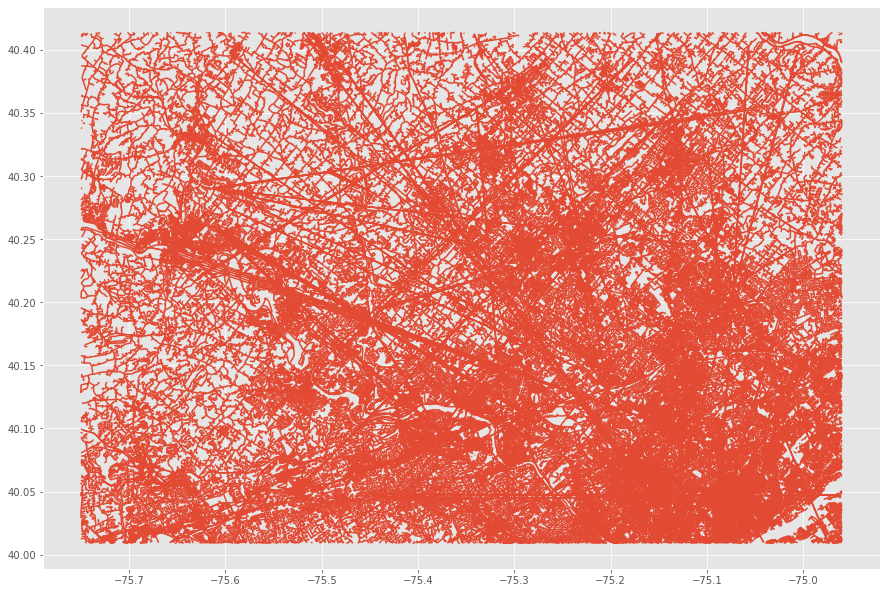

In [6]:
#Plotting the county map
fig,ax = plt.subplots(figsize = (15,15))
street_map.plot(ax=ax)

In [7]:
# Converting longitude and latitude to points
geometry = [Point(xy) for xy in zip( df["lng"], df["lat"] )]

In [8]:
geo_df = gpd.GeoDataFrame(df,
                         crs = crs,
                         geometry = geometry)
geo_df["geometry"] = geo_df["geometry"].to_crs(crs)
geo_df.head()

,lat,lng,zip,timeStamp,twp,emergency,geometry
7926,40.187874,-75.473836,19426,2016-01-01 00:29:01,TRAPPE,Traffic,POINT (-75.47384 40.18787)
7927,40.139510,-75.042015,19006,2016-01-01 00:38:04,LOWER MORELAND,Traffic,POINT (-75.04202 40.13951)
7929,40.187874,-75.473836,19426,2016-01-01 00:47:38,TRAPPE,Traffic,POINT (-75.47384 40.18787)
7933,40.147745,-75.353854,19403,2016-01-01 00:52:20,EAST NORRITON,Traffic,POINT (-75.35385 40.14774)
7939,40.145756,-75.309922,19401,2016-01-01 01:48:20,EAST NORRITON,Traffic,POINT (-75.30992 40.14576)


In [9]:
#convert the shape to polygon
city_polygon = street_map.geometry.unary_union
city_polygon = city_polygon.convex_hull 

#Leaving points within the boundary of the city
within_city = geo_df[geo_df.geometry.within(city_polygon)]
#outside_city = df[~df.geometry.within(chicago)]

### how many traffic emrgency calls per month of the year?

<AxesSubplot:xlabel='timeStamp'>

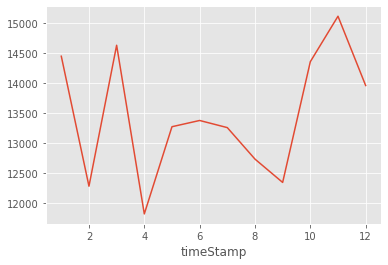

In [10]:
within_city["emergency"].groupby(within_city['timeStamp'].dt.month).count().plot.line()

<AxesSubplot:xlabel='timeStamp'>

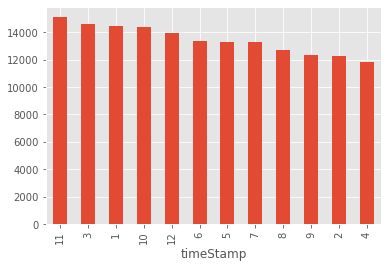

In [11]:
within_city["emergency"].groupby(within_city['timeStamp'].dt.month).count().sort_values(ascending=False).plot.bar()

The line plots show a significant increase in car accidents between October - January. It is possible to relate this increase with winter.There's also a possibility that the increase in November caused by the Thanksgiving weekend. The sharp rise in March could be associated with the spring break. 

### how many traffic emrgency calls per day of the month?

<AxesSubplot:xlabel='timeStamp'>

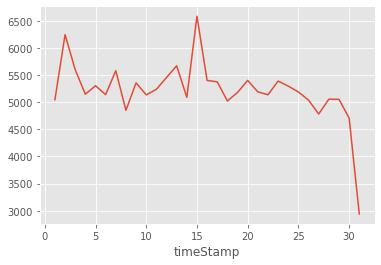

In [12]:
within_city["emergency"].groupby(within_city['timeStamp'].dt.day).count().plot.line()

<AxesSubplot:xlabel='timeStamp'>

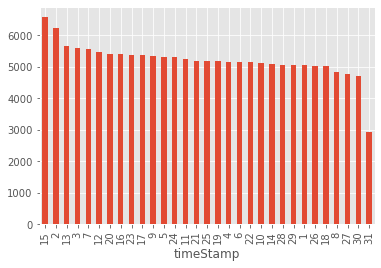

In [13]:
within_city["emergency"].groupby(within_city['timeStamp'].dt.day).count().sort_values(ascending=False).plot.bar()

The plots show a significant increase in car accidents on the 15th—this information deserves further investigation.

### How many traffic incidents calls per day of the week?

<AxesSubplot:xlabel='timeStamp'>

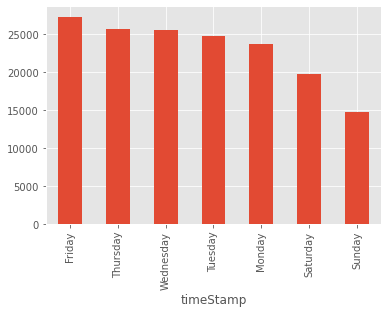

In [14]:
within_city["emergency"].groupby(within_city['timeStamp'].dt.day_name()).count().sort_values(ascending=False).plot.bar()

No wonder that Friday night has the most accidents. What is surprising is that Saturday, which is associated with partying and DUIs, has the lowest number of car accidents.

## Focus on December 2019

### how many call did we get for each  type in the month of December?

In [15]:
#Setting the start and end dates
start_date = datetime(2019,12,1)
end_date = datetime(2019,12,31)

In [16]:
december_calls = within_city["emergency"][(within_city["timeStamp"]>start_date) & (within_city["timeStamp"]<=end_date)]
december_calls.value_counts()

Traffic    3322
Name: emergency, dtype: int64

### How many traffic incidents calls per day of the week in December?

In [17]:
#Creating a data set for Traffic incedents in December
traffic_december = within_city[(within_city["emergency"] == "Traffic") & (within_city["timeStamp"]>start_date) & (within_city["timeStamp"]<=end_date)]

<AxesSubplot:xlabel='timeStamp'>

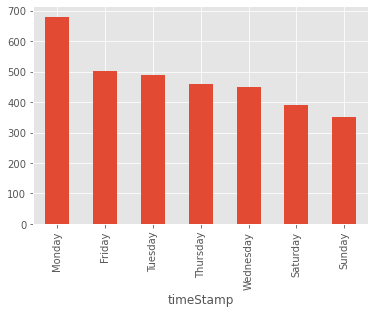

In [18]:
traffic_december["emergency"].groupby(traffic_december['timeStamp'].dt.day_name()).count().sort_values(ascending=False).plot.bar()

This chart shows that most accidents happen on Monday in December 2019, which is very different from what the data showed in between 2016 - 2019.

### Where did the traffic incidents happen in the county?

<IPython.core.display.Javascript object>


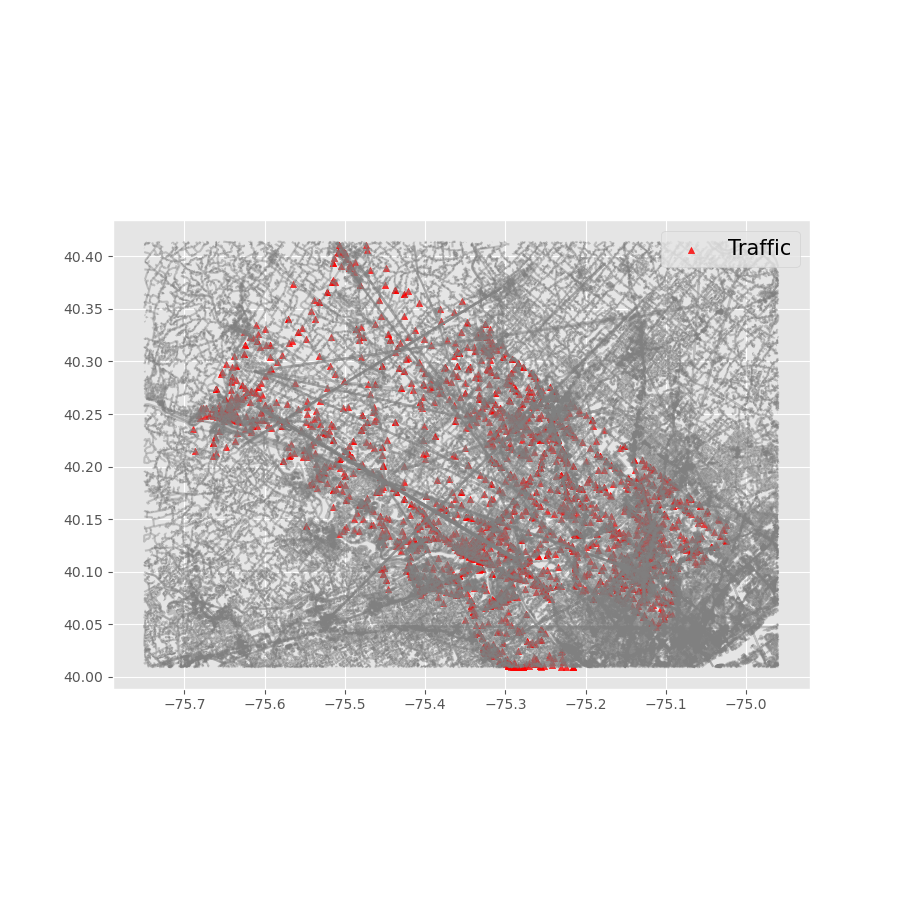

In [20]:
%matplotlib notebook
fig,ax = plt.subplots(figsize = (9,9))
street_map.plot(ax=ax, alpha = 0.4, color="grey")
traffic_december.plot(ax = ax, alpha=0.8, markersize = 20, color = "red", marker = "^", label = "Traffic")
plt.legend(prop={'size':15})

**Summary:** With these three plots, we found out the distribution of the frequency calls, where we have the most car accidents, and which days most of these accidents occur. This can be helpful information to share with the public and the local police department.